In [ ]:
i = []
while True:
  i.append(i)

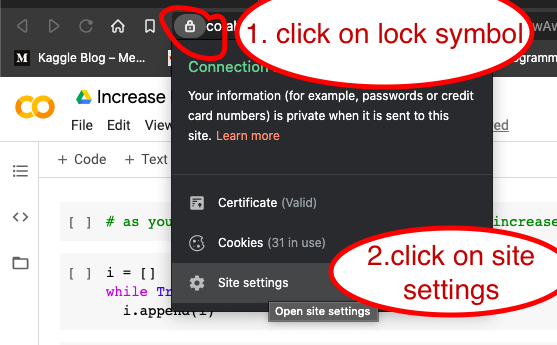

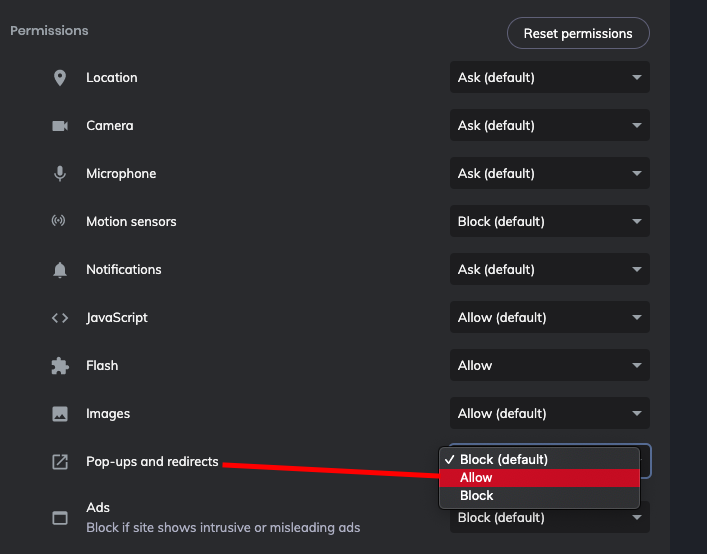

In [ ]:
!pip install -U mxnet-cu101==1.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━ 514.2/846.0 MB 103.0 MB/s eta 0:00:04
ERROR: Operation cancelled by user


In [ ]:
!nvidia-smi

Wed Mar 22 14:13:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/derive')

Mounted at /content/derive


**Setup**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

**Gather Flower Dataset**

In [ ]:
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
)

In [ ]:
from tensorflow import keras

train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/derive/MyDrive/Dataset3_split/train',
    labels='inferred',
    batch_size=None,
    image_size=(224, 224),
)
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/derive/MyDrive/Dataset3_split/val',
    labels='inferred',
    batch_size=None,
    image_size=(224, 224),
)

Found 2942 files belonging to 3 classes.
Found 737 files belonging to 3 classes.


In [ ]:
train_ds

<ShuffleDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

**Visualise the dataset**

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(str(label))
    plt.axis("off")

**Define hyperparameters**

In [2]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 3  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

**Define preprocessing helper functions**

In [ ]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE


@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

**Define the data pipeline**

In [ ]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(100)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

**Visualise the training samples**

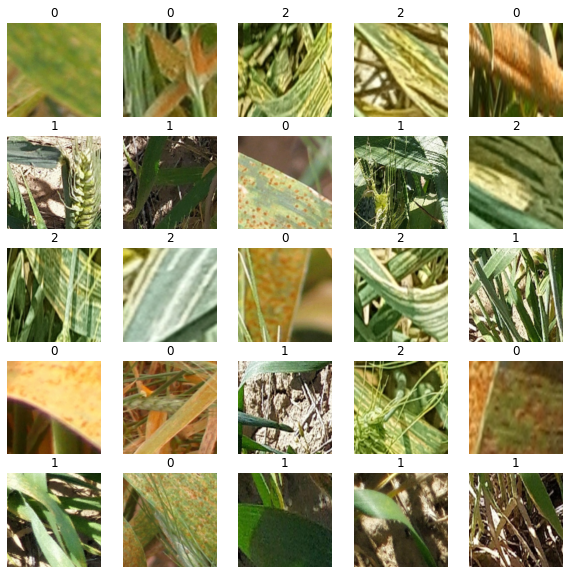

In [ ]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

**Load pretrained TF-Hub model into a KerasLayer**

In [6]:
#bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
#"https://tfhub.dev/google/bit/s-r152x4/1"
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

**Create BigTransfer (BiT) model**

In [7]:

class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=3, module=bit_module)
model.summary()

ValueError: ignored

**Define optimizer and loss**

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

**Compile the model**

In [ ]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

**Set up callbacks**

In [ ]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

**Train the model**

In [ ]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/50


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


10/10 [==============================] - 159s 13s/step - loss: 0.9549 - accuracy: 0.6578 - val_loss: 0.7223 - val_accuracy: 0.8290
Epoch 2/50
10/10 [==============================] - 64s 7s/step - loss: 0.5663 - accuracy: 0.9125 - val_loss: 0.4089 - val_accuracy: 0.9457
Epoch 3/50
10/10 [==============================] - 52s 6s/step - loss: 0.3723 - accuracy: 0.9250 - val_loss: 0.2734 - val_accuracy: 0.9539
Epoch 4/50
10/10 [==============================] - 48s 5s/step - loss: 0.2730 - accuracy: 0.9328 - val_loss: 0.2157 - val_accuracy: 0.9620
Epoch 5/50
10/10 [==============================] - 30s 3s/step - loss: 0.2277 - accuracy: 0.9547 - val_loss: 0.1861 - val_accuracy: 0.9674
Epoch 6/50
10/10 [==============================] - 48s 5s/step - loss: 0.1878 - accuracy: 0.9703 - val_loss: 0.1636 - val_accuracy: 0.9701
Epoch 7/50
10/10 [==============================] - 48s 5s/step - loss: 0.1749 - accuracy: 0.9672 - val_loss: 0.1470 - val_accuracy: 0.9715
Epoch 8/50
10/10 [===========

In [ ]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/400
10/10 [==============================] - ETA: 0s - loss: 1.2830 - accuracy: 0.6109

**Plot the training and validation metrics**

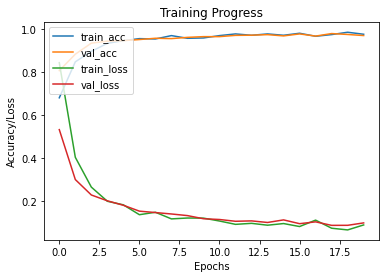

In [ ]:

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

**Evaluate the model**

In [ ]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

19/19 [==============================] - 24s 1s/step - loss: 0.0884 - accuracy: 0.9798
Accuracy: 97.98%


In [ ]:
https://tfhub.dev/google/collections/bit/1

https://tfhub.dev/google/collections/bit/1